In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from utils import misc
import datetime as dt
from trade_obj import *

from simple_backtester import backTester
df = pd.read_csv('datasets/daily_price_series/SPY.csv')
df = misc.clean_df(df)
df = df.set_index('date')

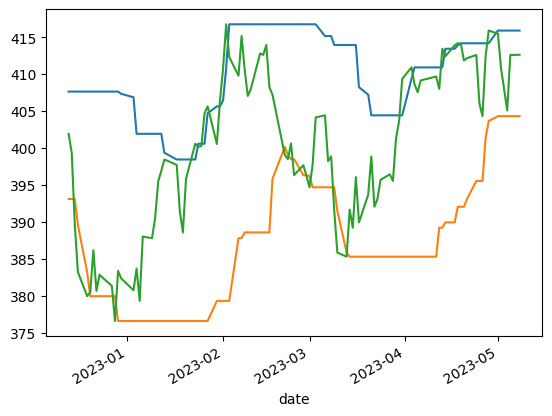

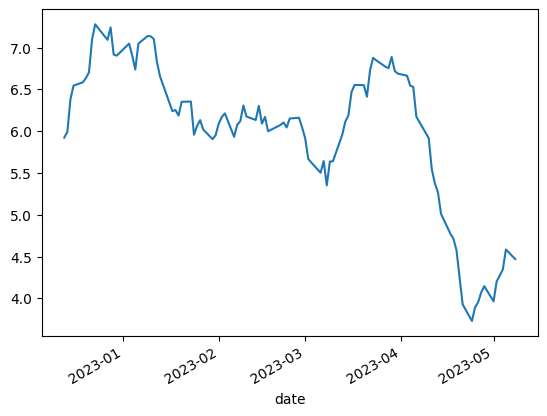

In [125]:
df['20_up_bound'] = df['close'].shift(1).rolling(20).max()
df['20_low_bound'] = df['close'].shift(1).rolling(20).min()
df['10_up_bound'] = df['close'].shift(1).rolling(10).max()
df['10_low_bound'] = df['close'].shift(1).rolling(10).min()


df = df.dropna()


df['High-Low'] = df['high'] - df['low']
df['High-PrevClose'] = abs(df['high'] - df['close'].shift(1))
df['Low-PrevClose'] = abs(df['low'] - df['close'].shift(1))
df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)
df['ATR'] = df['TR'].rolling(20).mean()


df1 = df[-100:].copy()
df1['20_up_bound'].plot()
df1['20_low_bound'].plot()
df1['close'].plot()
plt.show()

df1['ATR'].plot()
plt.show()

In [126]:
bt = backTester()
df = df.dropna()
df = df[-500:]
bt.set_asset(df)

upbound20 = df['20_up_bound'].to_numpy()
lowbound20 = df['20_low_bound'].to_numpy()
upbound10 = df['10_up_bound'].to_numpy()
lowbound10 = df['10_low_bound'].to_numpy()

atr = df['ATR'].to_numpy()
stop_loss_arr = []
stop_loss = np.nan
tl = tradeList()
entry_exit = np.nan
entry_exit_arr = []




for i in range(len(bt.df)):
    print(f'--- index {i}, date: {bt.date[i]} ---')
    order_quantity = 0
    order_price = 0
    n = 2 * atr[i]
    risk_unit = int(bt.portfolio_value * 0.02 / n)
    entry_exit = np.nan


    # no open trades
    if len(tl.open_trades) == 0:
        # breakout from 20 day high
        if bt.high[i] > upbound20[i]:
            print(f'high: {bt.high[i]} > long breakout: {upbound20[i]}')
            # order price at breakout
            order_price = upbound20[i]
            # order 1 unit
            order_quantity = risk_unit
            # entry price
            long_entry_price = order_price
            
            # open trade on record
            tl.open_trades.append(trade(bt.date[i], order_price, order_quantity, type='long'))
            print(f'entry price: {order_price}, quantity: {order_quantity}')
            
            # calculate stop_loss
            stop_loss = order_price - n
            print(f'stop_loss {stop_loss}')

            entry_exit = order_price
            
            
            
    # open trades present 
    else:
        # if open trades are long
        if tl.open_trades[0].type == 'long':
            pass
            # calculate trailing stop_loss
            stop_loss = max(stop_loss, bt.high[i] - n)
            print(f'stop_loss {stop_loss}')
            print(f'lowbound10 {lowbound10[i]}')
            # combine low bound 10 and trailing stop loss
            stop_loss = max(stop_loss, lowbound10[i])
            

            # exit trade if stop loss is triggered
            if bt.low[i] < stop_loss:
                print(f'low: {bt.low[i]} < stop_loss: {stop_loss}')
                # exit price at stoploss
                order_price = stop_loss
                for t in tl.open_trades:
                    print(f'exiting trade quantity {t.quantity}')
                    order_quantity += -t.quantity
                    t.close(bt.date[i], order_price)
                    tl.append(t)
                
                tl.open_trades = []
                stop_loss = np.nan

                entry_exit = order_price
        

            # add trade if stop loss is at entry price
            elif stop_loss >= long_entry_price:
                print('add new trade')
                order_price = bt.high[i]
                order_quantity = risk_unit
                long_entry_price = order_price

                tl.open_trades.append(trade(bt.date[i], order_price, order_quantity, type='add'))
                print(f'entry price: {order_price}, quantity: {order_quantity}')
                print(f'num open trades: {len(tl.open_trades)}')
                entry_exit = order_price


        
    stop_loss_arr.append(stop_loss)
    entry_exit_arr.append(entry_exit)
    bt.take_action(order_quantity=order_quantity, order_price=order_price)
            

df['stop_loss'] = stop_loss_arr
df['entry_exit'] = entry_exit_arr

        


--- index 0, date: 2021-05-13 00:00:00 ---
--- index 1, date: 2021-05-14 00:00:00 ---
--- index 2, date: 2021-05-17 00:00:00 ---
--- index 3, date: 2021-05-18 00:00:00 ---
--- index 4, date: 2021-05-19 00:00:00 ---
--- index 5, date: 2021-05-20 00:00:00 ---
--- index 6, date: 2021-05-21 00:00:00 ---
--- index 7, date: 2021-05-24 00:00:00 ---
--- index 8, date: 2021-05-25 00:00:00 ---
--- index 9, date: 2021-05-26 00:00:00 ---
--- index 10, date: 2021-05-27 00:00:00 ---
--- index 11, date: 2021-05-28 00:00:00 ---
--- index 12, date: 2021-06-01 00:00:00 ---
high: 422.7200012207031 > long breakout: 422.1199951171875
entry price: 422.1199951171875, quantity: 2069
stop_loss 412.4569946289063
--- index 13, date: 2021-06-02 00:00:00 ---
stop_loss 412.4569946289063
lowbound10 410.8599853515625
--- index 14, date: 2021-06-03 00:00:00 ---
stop_loss 412.4569946289063
lowbound10 410.8599853515625
--- index 15, date: 2021-06-04 00:00:00 ---
stop_loss 413.69701232910154
lowbound10 414.9400024414063


In [127]:
print(len(bt.date))

500


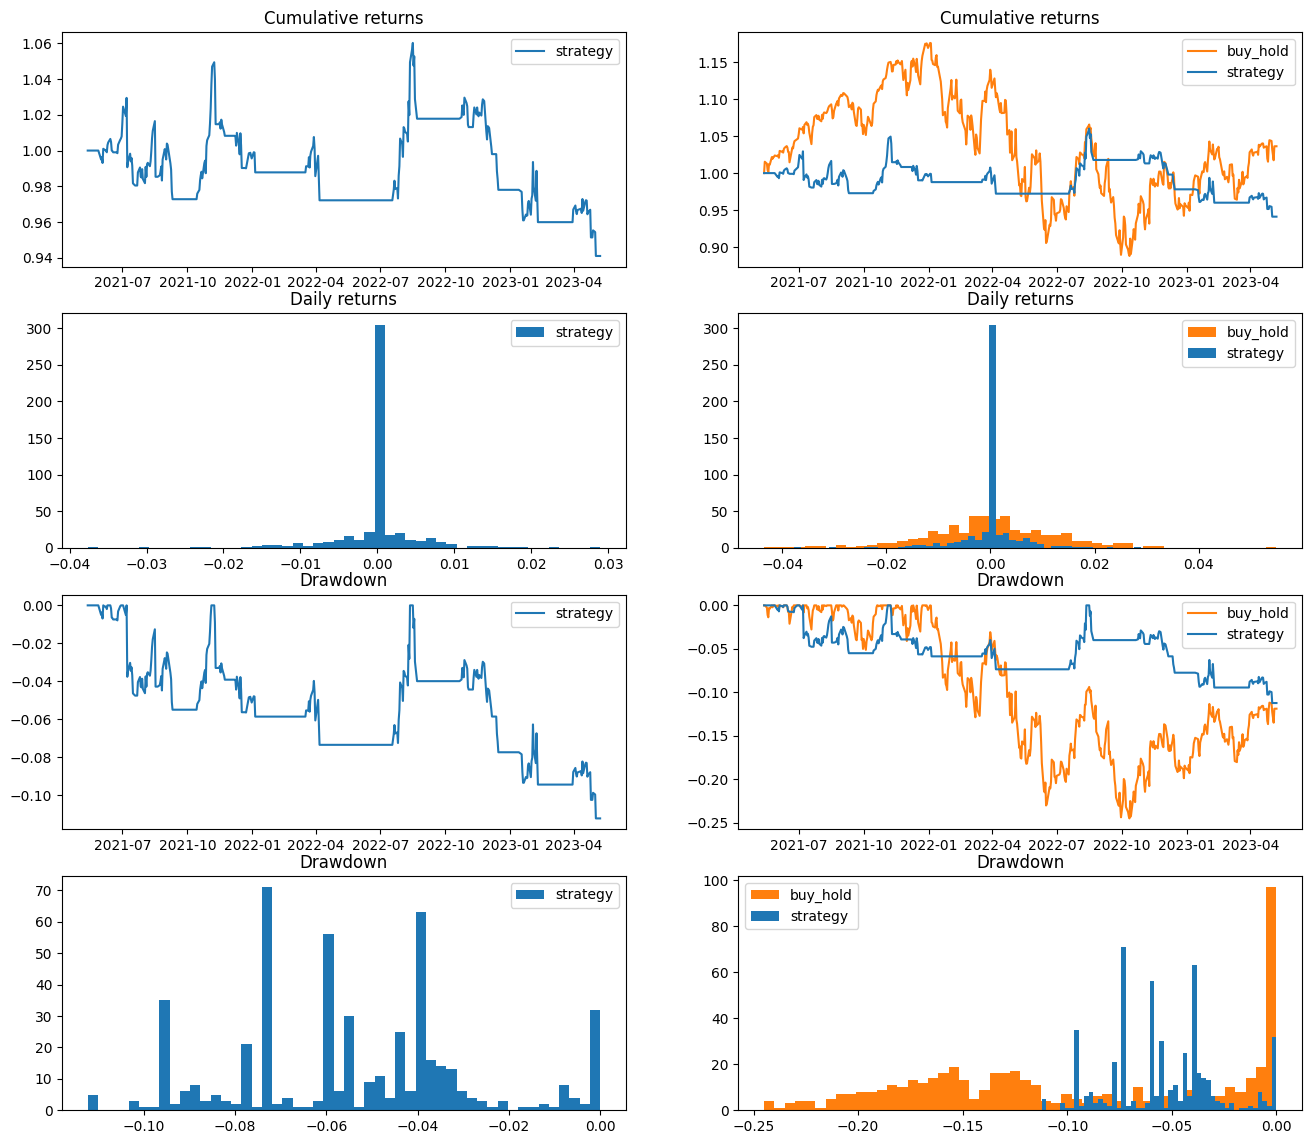

In [128]:
bt.analyse()
bt.plot_graphs()

In [129]:
print(f'Annualised return:          {bt.annual_return}')
print(f'buy_hold annual return:     {bt.buy_hold_annual_return}')
print(f'Annualised vol:             {bt.annual_vol}')
print(f'buy_hold annual vol:        {bt.buy_hold_annual_vol}')
print(f'Sharpe ratio:               {bt.sharpe}')
print(f'buy_hold Sharpe ratio:      {bt.buy_hold_sharpe}')

Annualised return:          -0.03012417750109797
buy_hold annual return:     0.01812607156449353
Annualised vol:             0.08356124438105206
buy_hold annual vol:        0.19617911153377826
Sharpe ratio:               -0.3605041754013034
buy_hold Sharpe ratio:      0.09239552275866317


In [130]:
tl.analyse(bt.df)
tl.stats

{'num_wins': 11,
 'num_loss': 19,
 'win_rate': 0.36666666666666664,
 'profit_total': -58907.53279418971,
 'profit_mean': -1963.5844264729903,
 'returns_mean': -0.0010631541093926494,
 'returns_std': 0.022979529847108087,
 'time_in_trade_mean': 13.2,
 'time_in_trade_std': 8.07892106145625,
 'capital_at_risk_mean': 846748.9669626872,
 'win_returns_mean': 0.021827592315353937,
 'win_returns_std': 0.021315132330776376,
 'win_profit_mean': 13863.497837413452,
 'win_time_in_trade_mean': 21.90909090909091,
 'win_time_in_trade_std': 5.647203652331753,
 'loss_returns_mean': -0.014315691513193306,
 'loss_returns_std': 0.009630801596955637,
 'loss_profit_mean': -11126.632052933559,
 'loss_time_in_trade_mean': 8.157894736842104,
 'loss_time_in_trade_std': 3.775110857750285}

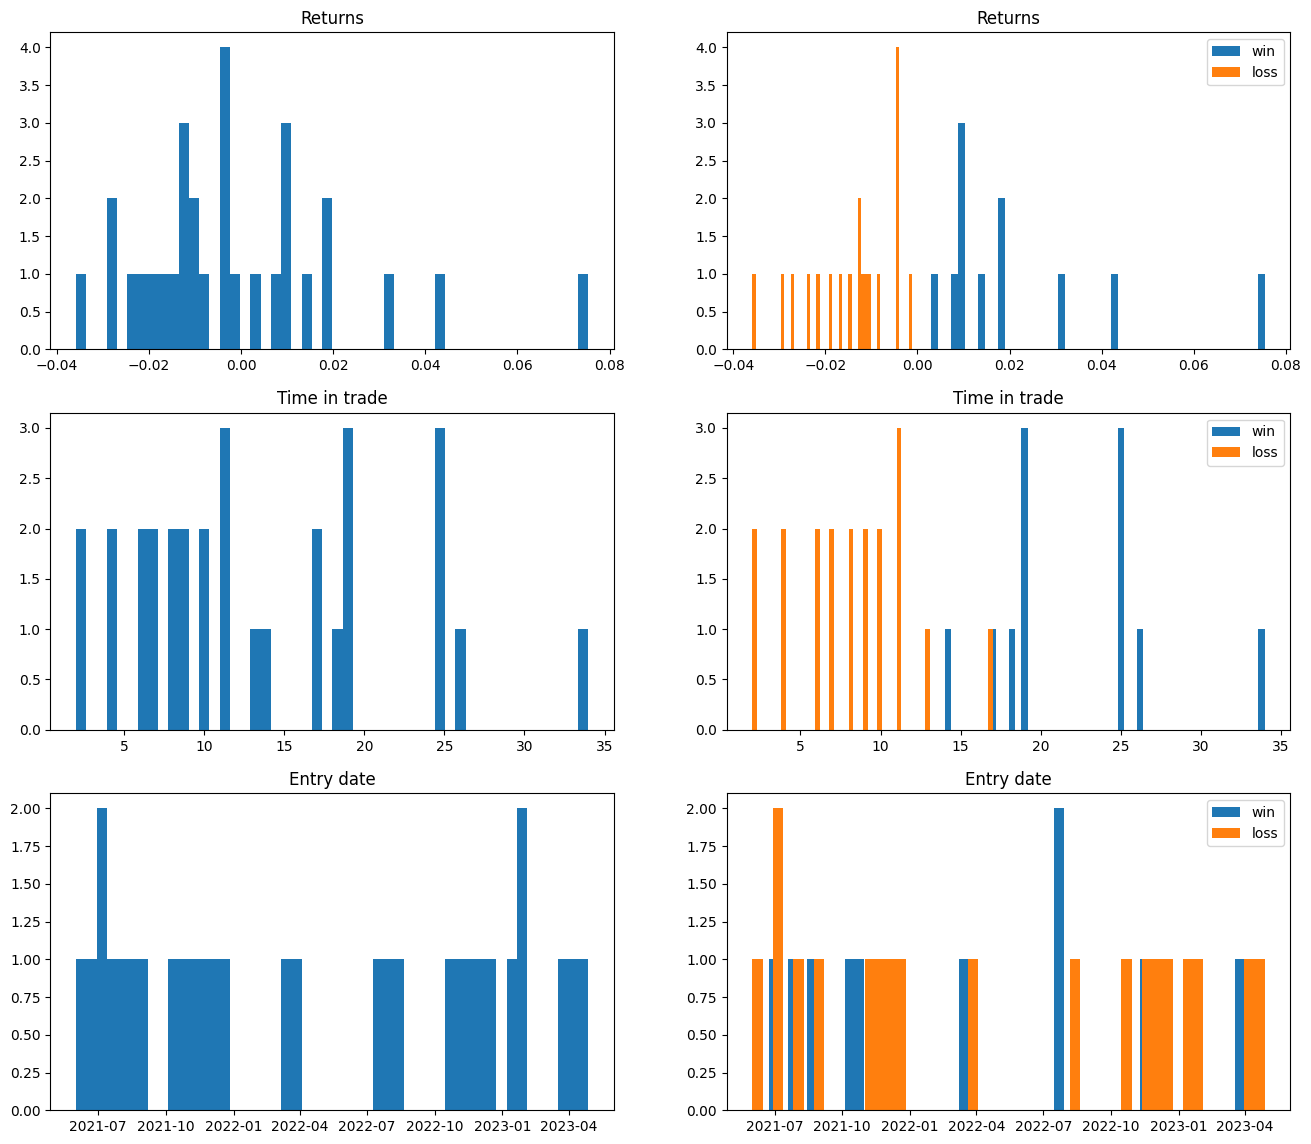

In [131]:
tl.plot_graphs()

trade 0
entry: 414.2099914550781, exit: 409.69398803710936
returns: -0.010902690691029674
14


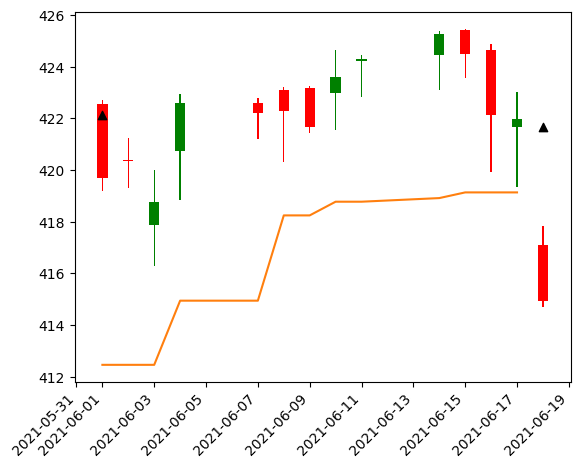

trade 1
entry: 422.1199951171875, exit: 421.6499938964844
returns: -0.0011134303661039437
10


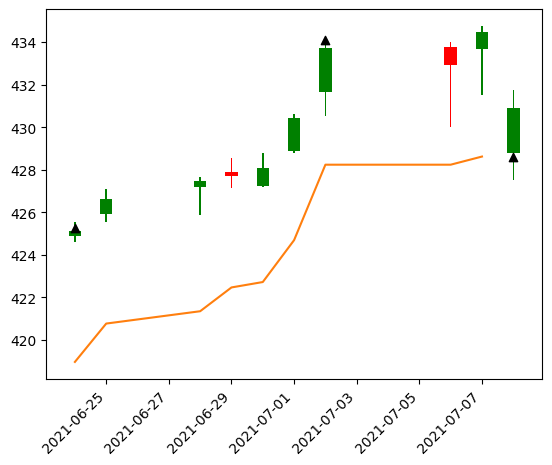

trade 2
entry: 425.260009765625, exit: 428.61602172851565
returns: 0.007891670709268567
4


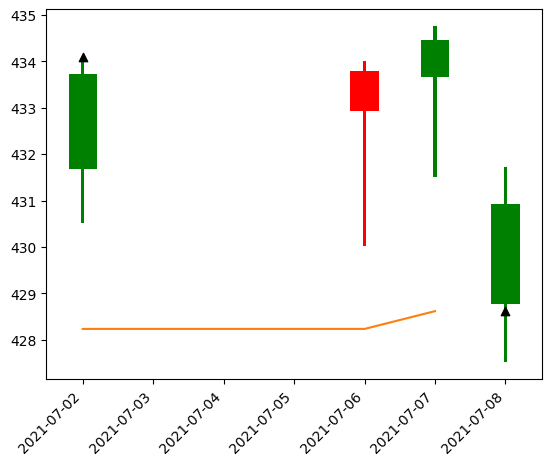

trade 3
entry: 434.1000061035156, exit: 428.61602172851565
returns: -0.012632997691532546
7


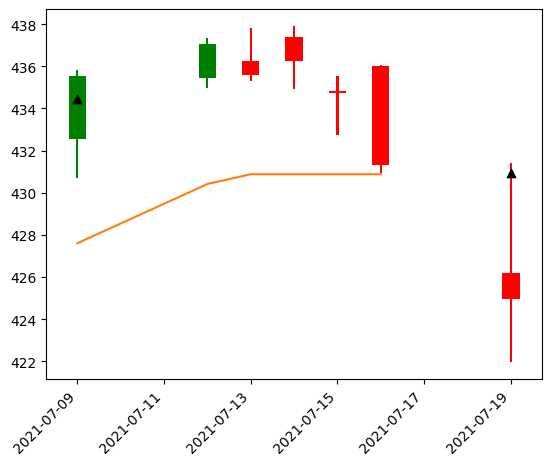

trade 4
entry: 434.4599914550781, exit: 430.9200134277344
returns: -0.008147995435639033
18


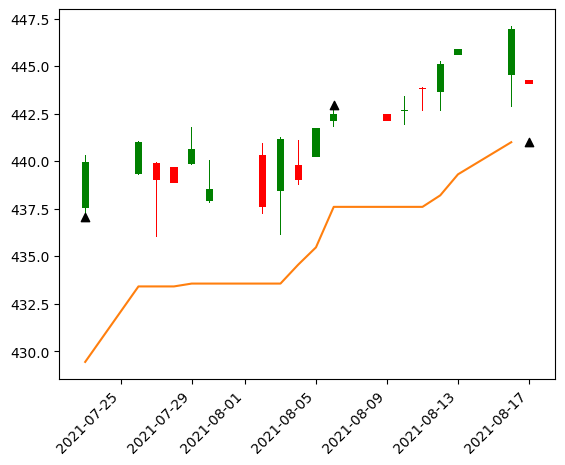

trade 5
entry: 437.0799865722656, exit: 440.99198913574213
returns: 0.008950312720003037
8


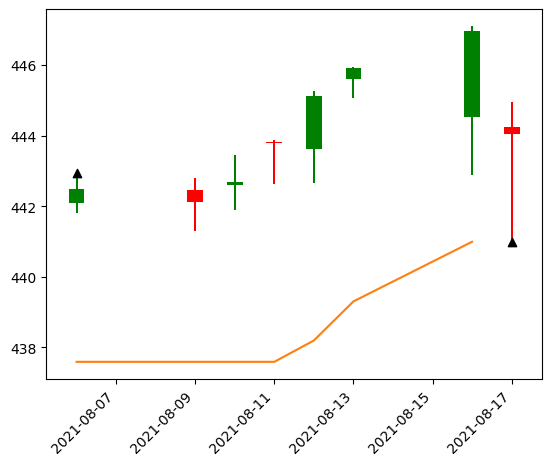

trade 6
entry: 442.9400024414063, exit: 440.99198913574213
returns: -0.004397916862164343
14


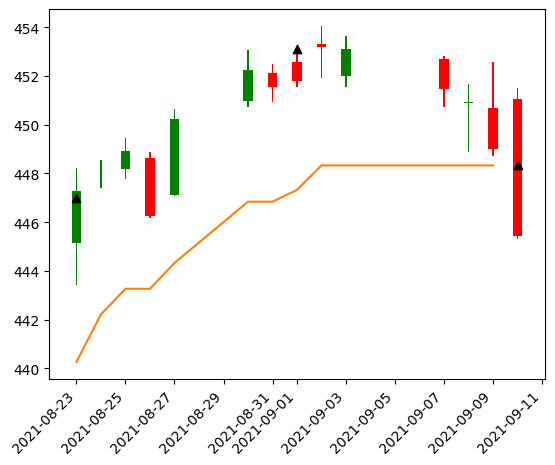

trade 7
entry: 446.9700012207031, exit: 448.3269897460938
returns: 0.0030359722614149206
7


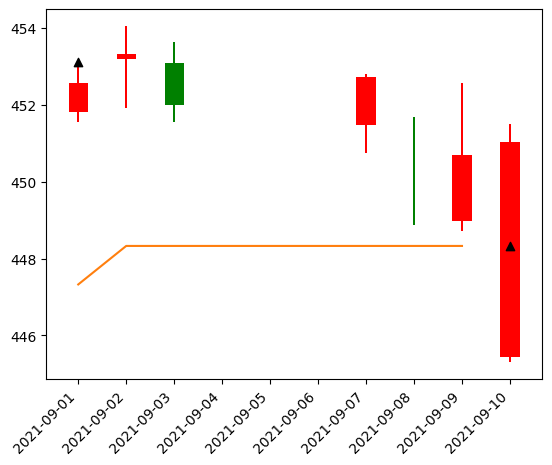

trade 8
entry: 453.1099853515625, exit: 448.3269897460938
returns: -0.010555926287428116
19


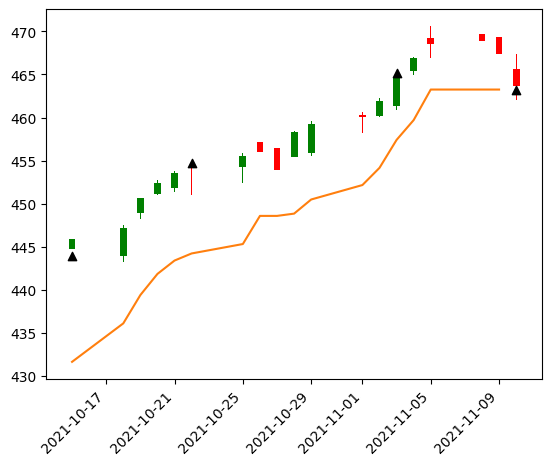

trade 9
entry: 443.9100036621094, exit: 463.2519927978516
returns: 0.04357187037051938
14


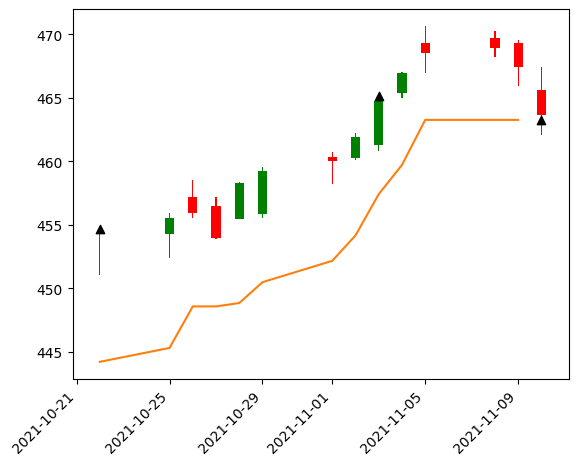

trade 10
entry: 454.6700134277344, exit: 463.2519927978516
returns: 0.018875182256727463
6


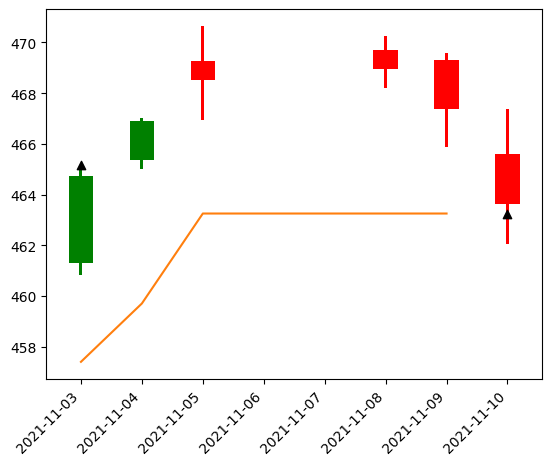

trade 11
entry: 465.1499938964844, exit: 463.2519927978516
returns: -0.0040804065861283784
6


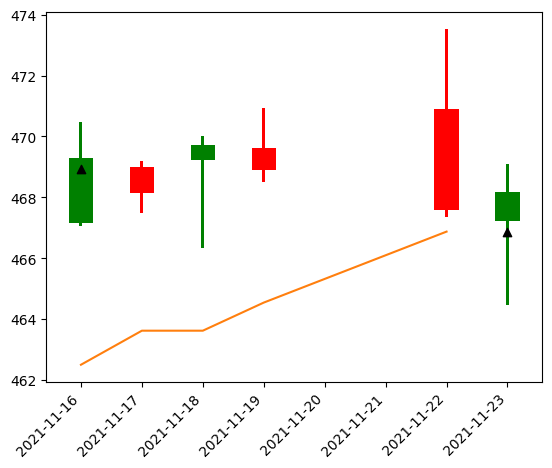

trade 12
entry: 468.9299926757813, exit: 466.87500915527346
returns: -0.004382282115890728
8


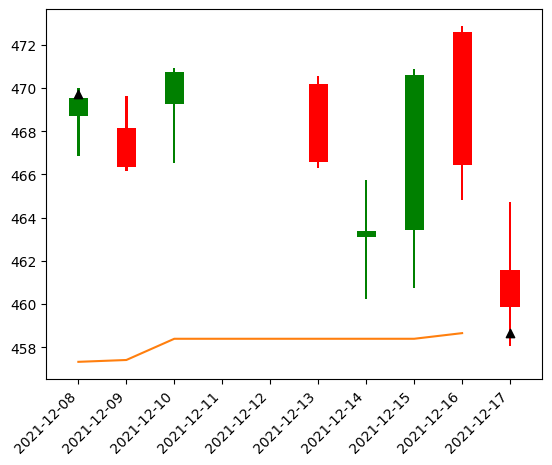

trade 13
entry: 469.7300109863281, exit: 458.6499908447266
returns: -0.023588060976423422
9


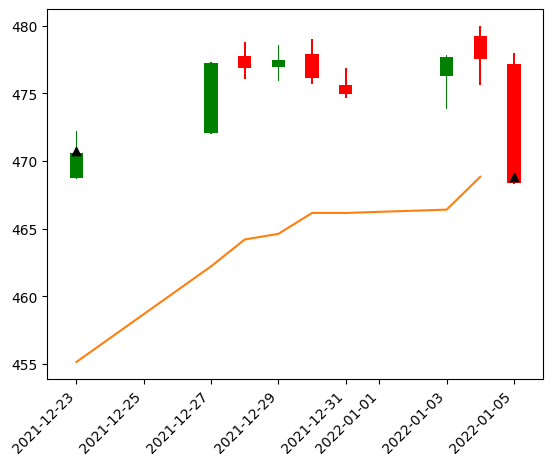

trade 14
entry: 470.739990234375, exit: 468.82801513671876
returns: -0.004061637288780782
14


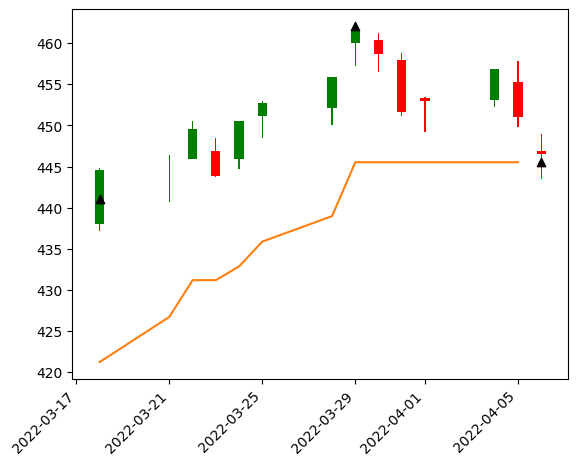

trade 15
entry: 441.0700073242188, exit: 445.5210113525391
returns: 0.010091377682474107
7


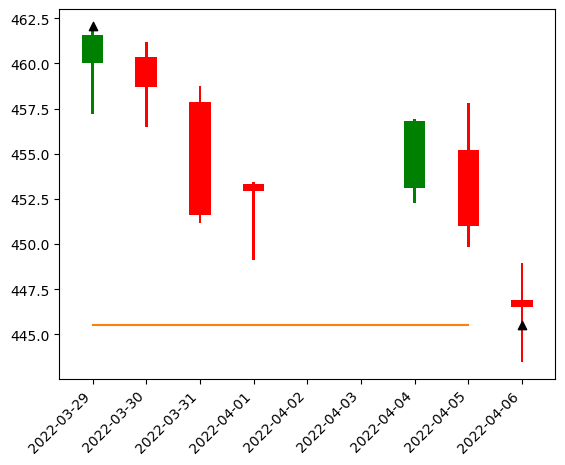

trade 16
entry: 462.0700073242188, exit: 445.5210113525391
returns: -0.0358149105316585
25


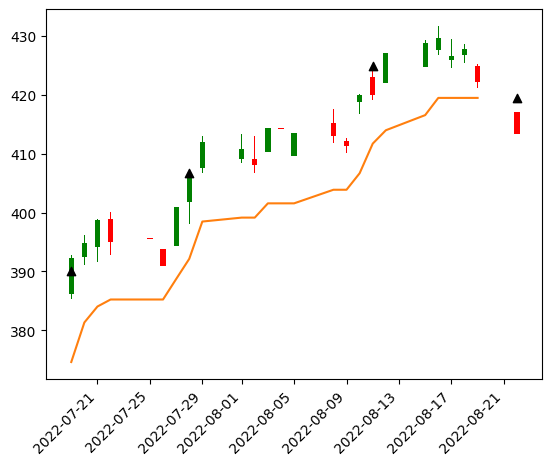

trade 17
entry: 390.0799865722656, exit: 419.5060089111328
returns: 0.07543586790350697
18


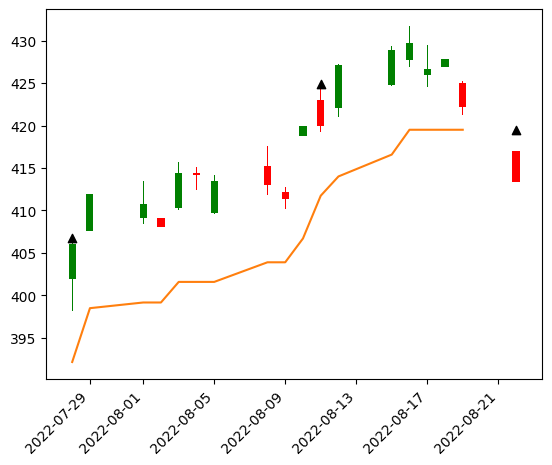

trade 18
entry: 406.7999877929688, exit: 419.5060089111328
returns: 0.031234074482397584
8


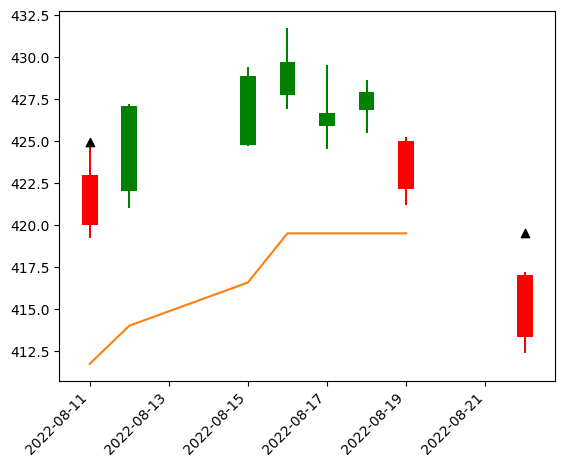

trade 19
entry: 424.9500122070313, exit: 419.5060089111328
returns: -0.01281092631960255
9


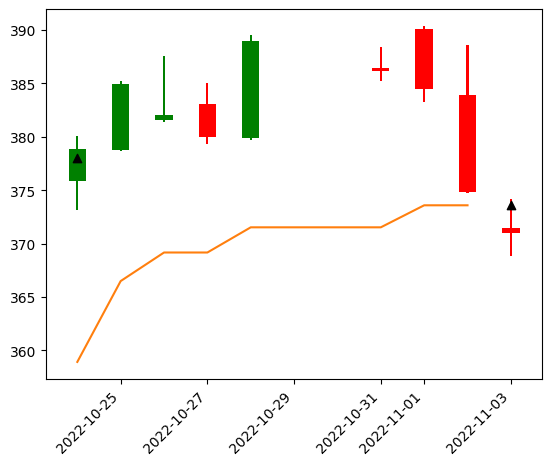

trade 20
entry: 377.9700012207031, exit: 373.5840087890625
returns: -0.011604075501959073
13


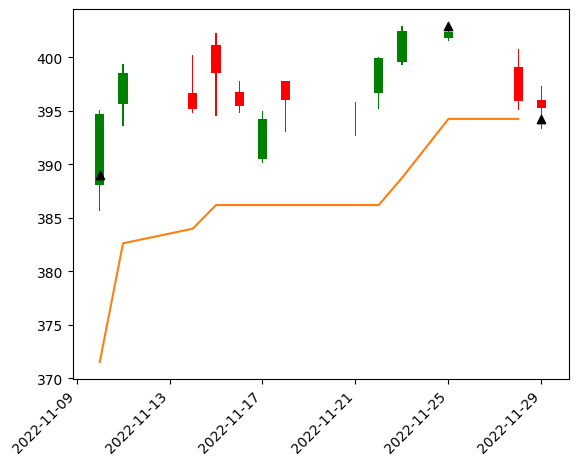

trade 21
entry: 389.0199890136719, exit: 394.239990234375
returns: 0.013418336764488652
3


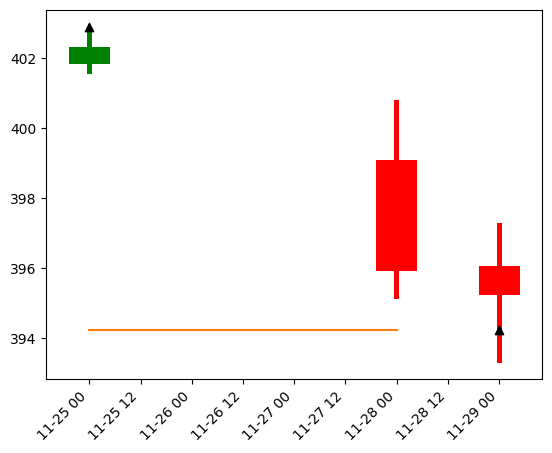

trade 22
entry: 402.9100036621094, exit: 394.239990234375
returns: -0.021518486383885545
5


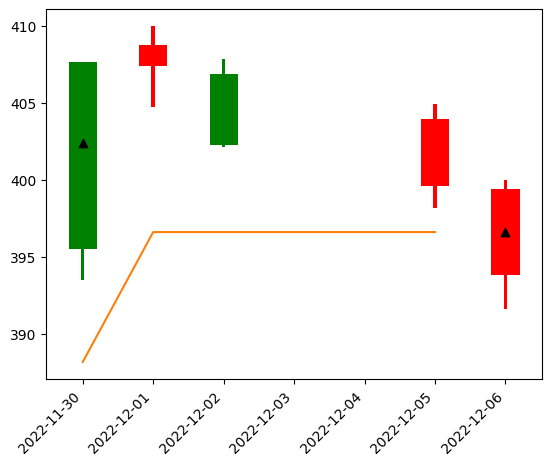

trade 23
entry: 402.4200134277344, exit: 396.611001586914
returns: -0.014435196180578418
3


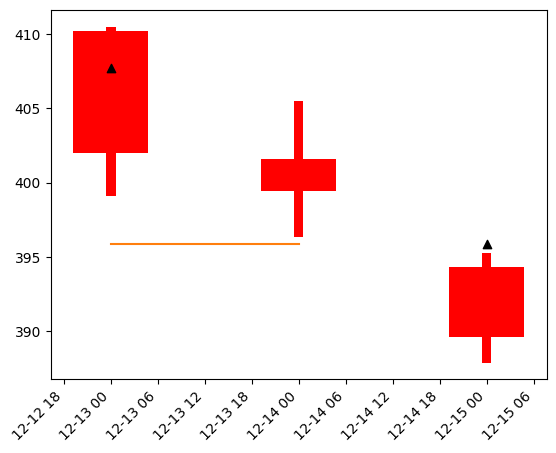

trade 24
entry: 407.6799926757813, exit: 395.8330047607422
returns: -0.02905952739373391
3


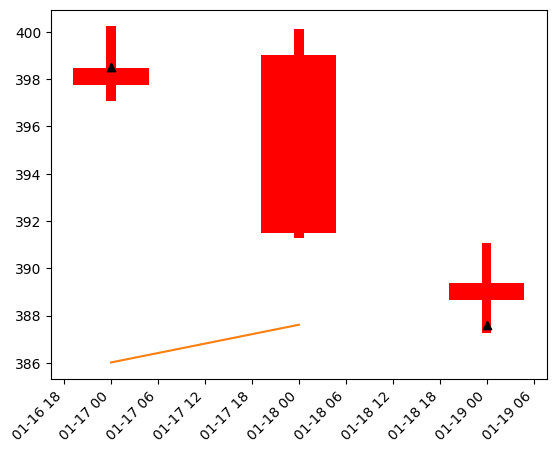

trade 25
entry: 398.5, exit: 387.61298828124995
returns: -0.02731997921894616
14


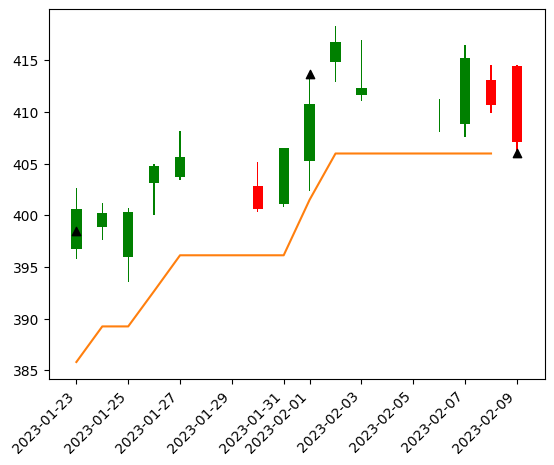

trade 26
entry: 398.5, exit: 405.97099609375
returns: 0.018747794463613524
7


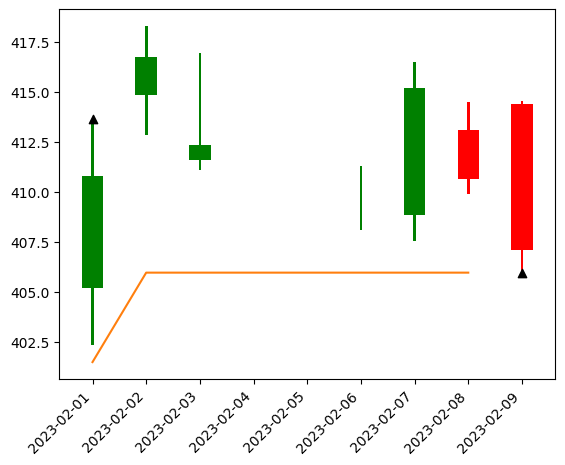

trade 27
entry: 413.6700134277344, exit: 405.97099609375
returns: -0.01861149487290395
17


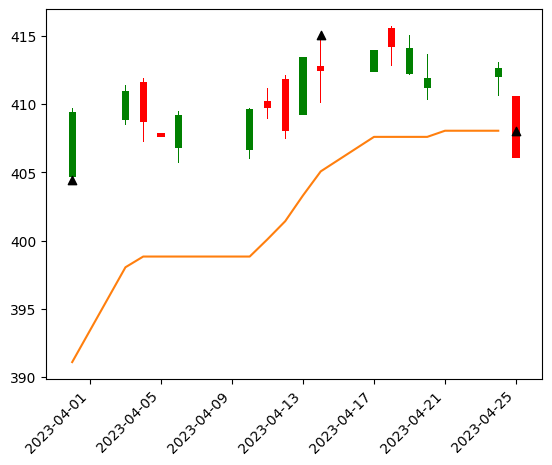

trade 28
entry: 404.4700012207031, exit: 408.0499877929688
returns: 0.008851055854479123
8


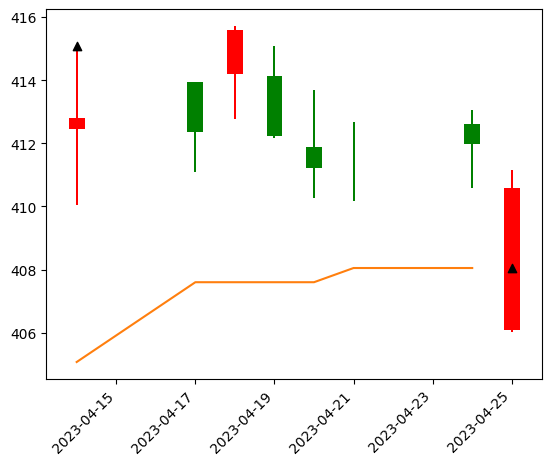

trade 29
entry: 415.0899963378906, exit: 408.0499877929688
returns: -0.01696019804628374
3


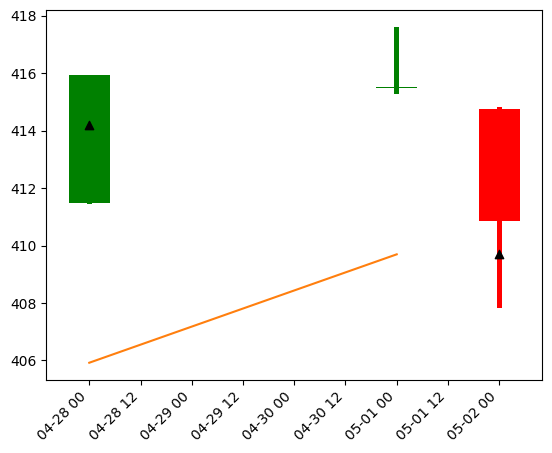

In [132]:
def plot_candle(df, show=False):
    #define width of candlestick elements
    width = .4
    width2 = .05

    #define up and down t.df
    up = df[df.close>=df.open].copy()
    down = df[df.close<df.open].copy()

    #define colors to use
    col1 = 'green'
    col2 = 'red'

    #plot up t.df
    plt.bar(up.index,up.close-up.open,width,bottom=up.open,color=col1)
    plt.bar(up.index,up.high-up.close,width2,bottom=up.close,color=col1)
    plt.bar(up.index,up.low-up.open,width2,bottom=up.open,color=col1)

    #plot down t.df
    plt.bar(down.index,down.close-down.open,width,bottom=down.open,color=col2)
    plt.bar(down.index,down.high-down.open,width2,bottom=down.open,color=col2)
    plt.bar(down.index,down.low-down.close,width2,bottom=down.close,color=col2)

    #rotate x-axis tick labels
    plt.xticks(rotation=45, ha='right')

    if show:
        #display candlestick chart
        plt.show()


for i in range(len(tl.list)):

    print(f'trade {i}')
    print(f'entry: {t.entry_price}, exit: {t.exit_price}')
    print(f'returns: {t.returns}')
    
    t = tl.list[i]
    plot_candle(t.df)
    print(len(t.df))
    
    
    plt.plot(t.df['stop_loss'], color='C1')
    plt.scatter(t.df.index, t.df['entry_exit'], marker='^', color='black')
    plt.show()



<Axes: >

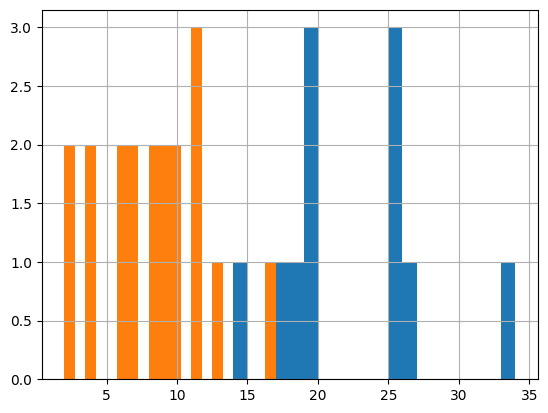

In [133]:
tl.win_records['time_in_trade'].hist(bins=20)
tl.loss_records['time_in_trade'].hist(bins=20)

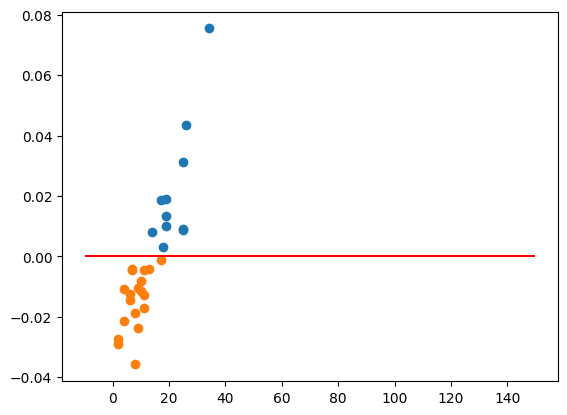

In [134]:
plt.scatter(tl.win_records['time_in_trade'], tl.win_records['returns'])
plt.scatter(tl.loss_records['time_in_trade'], tl.loss_records['returns'])
plt.hlines(0, -10, 150, color='red')